In [1]:
params = {"figure.figsize": (12,9),
          "font.size": 20,
          "font.weight": "normal",
          "xtick.major.size": 9,
          "xtick.minor.size": 4,
          "ytick.major.size": 9,
          "ytick.minor.size": 4,
          "xtick.major.width": 4,
          "xtick.minor.width": 3,
          "ytick.major.width": 4,
          "ytick.minor.width": 3,
          "xtick.major.pad": 8,
          "xtick.minor.pad": 8,
          "ytick.major.pad": 8,
          "ytick.minor.pad": 8,
          "lines.linewidth": 3,
          "lines.markersize": 10,
          "axes.linewidth": 4,
          "legend.loc": "best",
          "text.usetex": False,    
          "xtick.labelsize" : 20,
          "ytick.labelsize" : 20,
          }

import matplotlib
matplotlib.rcParams.update(params)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pyl
import math
import scipy as sp
import scipy.optimize as opt
import matplotlib.image as mpimg
import time
import astropy as ap
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.colors as colors
import os
import pandas as pd

%matplotlib inline

In [3]:
def format_galcoords(glong, glat):
    '''
    Transforms standard glong and glat (degrees) into wrapped radians
    
    The Galactic longitudes are wrapped such that the values are from
    -180 to 180 (instead of 0 to 360). Both the Galactic longitude and
    Galactic latitude values are then converted from degree to radians
    
    Args:
        glong (array): 1D array of Galactic longitudes
                       in degrees
        glat (array): 1D array pf Galactic latitudes
                      in degrees
                      
    Returns:
        Two arrays, the wrapped Galactic longitude in radians
        and the Galactic latitude in radians
    '''
    glong[np.where(glong>180)] = glong[np.where(glong>180)] - 360
    glong_rad = np.deg2rad(glong)
    glat_rad = np.deg2rad(glat)
    
    return glong_rad, glat_rad

In [4]:
def format_frb_info(frbcat, pushchino=False):
    FRB_info = pd.read_csv(frbcat)
    
    if not pushchino:
        FRB_info = FRB_info[FRB_info['telescope'] != 'Pushchino']
    
    FRB_info = FRB_info.replace('parkes', 'Parkes')
    FRB_info = FRB_info.replace('arecibo', 'Arecibo')

    unique_telescopes = np.unique(FRB_info['telescope'])

    all_colours = ['#C84630', '#FF7B9C',
                   'White', 'Black',
                   '#3cb44b', '#bfef45',
                   '#4363d8', '#42d4f4',
                   '#911eb4', '#764134',
                   '#FFC759', '#59C3C3',
                   '#f032e6', '#00A9A5']
    telescope_colour = dict()
    for t, tel in enumerate(unique_telescopes):
        telescope_colour[tel] = all_colours[t]

    colours = np.array(FRB_info['telescope'])
    for t, tel in enumerate(unique_telescopes):
        colours[np.where(colours==tel)] = telescope_colour[tel]
    FRB_info['telescope colours'] = colours

    formatted_dms = []
    for i, d in enumerate(FRB_info['rmp_dm']):
        if '&' in d:
            val = d[:d.index('&')]
            val = float(val)
        else:
            val = float(d)
        formatted_dms.append(val)
    FRB_info['DM'] = np.array(formatted_dms)
    FRB_info['logDM'] = np.log10(formatted_dms)

    glong_rad, glat_rad = format_galcoords(np.array(FRB_info['rop_gl']),
                                           np.array(FRB_info['rop_gb']))
    FRB_info['gl_rad'] = glong_rad
    FRB_info['gb_rad'] = glat_rad
    
    return FRB_info

## FRB catalogues

Load and format the FRB catalogues. FRB_cat is the latest frb catalogue from frbcat.org. This is deprecated in favour of the TNS server, but you'll still need the FRB cat file as it has not been well replecated in the TNS server.

The TNS server is the Transient Name Server and can be found here: https://www.wis-tns.org//

To get a csv of all of the TNS FRBs go to the above website and go to "search" in the menu at the top. Select "include FRBs" and FRB under "Object type". Set the "results in page" to as many as possible (I think 500). Click "download as CSV". This will be your TNS_cat file.

In [5]:
# The names aren't always consistent, which is annoying.
# So I made this disctionary to clear that up

telescope_dict = {'ASKAP': 'CRAFT',
                  'Arecibo': 'PALFA',
                  'CHIME/FRB': 'CHIMEFRB',
                  'DSA-10': 'DSA-10',
                  'FAST': 'FAST',
                  'GBT': 'GBNCC',
                  'Parkes': 'Parkes',
                  'UTMOST': 'UTMOST',
                  'VLA': 'VLA-realfast',
                  'Apertif': 'Apertif',
                  'Pushchino': 'Pushchino'}

In [6]:
# Read the FRBcat file and get the coordinates
FRB_cat = ('frbcat_20210526.csv')
FRB_cat_info = format_frb_info(FRB_cat, pushchino=True)

frb_cat_coords = coord.SkyCoord(np.array(FRB_cat_info['rop_raj']),
                                np.array(FRB_cat_info['rop_decj']),
                                unit=(u.hour, u.deg))

In [7]:
# Read the TNS file
TNS_cat = ('tns_search_20210526.csv')
FRB_info = pd.read_csv(TNS_cat)

FRB_info = FRB_info.sort_values(by=['Discovery Date (UT)'])

# Swap the naming of the reporting group for the
# FAST FRBs so that it actually has "FAST" in the label
FRB_info.loc[FRB_info['Sender'] == 'niu', 'Reporting Group/s'] = 'FAST'

# Split into repeating and non-repeating FRBs
nonrepeaters = FRB_info[FRB_info['Repeater of Primary Burst'].isna()]
repeaters = FRB_info[FRB_info['Repeater of Primary Burst'].notna()]
# Only keep one burst for each repeater
repeaters = repeaters.drop_duplicates(subset=['Repeater of Primary Burst'])

# recombine the repeaters and non-repeaters into
# one table
unique_frbs = pd.concat((nonrepeaters, repeaters), join='inner', ignore_index=True)

print('Number of repeaters: {}'.format(len(repeaters.index)))
print('Number of non-repeaters: {}'.format(len(nonrepeaters.index)))

# Get the coordinates for all of the FRBs
unique_frb_coords = coord.SkyCoord(np.array(unique_frbs['RA']),
                                   np.array(unique_frbs['DEC']),
                                   unit=(u.hour, u.deg))

Number of repeaters: 22
Number of non-repeaters: 120


In [8]:
frb_cat_rows = []
for c, coo in enumerate(unique_frb_coords):
    seps = coo.separation(frb_cat_coords)
    if np.nanmin(seps.deg) < 1./60.:
        frb_cat_rows.append(np.nanargmin(seps.deg))
        tele_name = telescope_dict[FRB_cat_info.iloc[np.nanargmin(seps.deg)]['telescope']]
        unique_frbs.loc[c, 'Reporting Group/s'] = tele_name

In [9]:
# Add the FRBcat FRBs to the TNS table. This is
# because the TNS server doesn't include all
# the info about the FRBcat FRBs and just says they
# are FRBcat FRBs, without info such as which
# telescope detected them.
cols = ['Name', 'RA', 'DEC', 'DM', 'Reporting Group/s']
col_info = []
for r, row in enumerate(range(len(FRB_cat_info.index))):
    if r not in frb_cat_rows:        
        frb_row = FRB_cat_info.iloc[r]
        
        col_info.append([frb_row['frb_name'],
                         frb_row['rop_raj'], frb_row['rop_decj'],
                         frb_row['DM'],
                         telescope_dict[frb_row['telescope']]])
col_info = np.array(col_info)

frbcat_frbs = pd.DataFrame(data=col_info, columns=cols)

In [10]:
# Put the FRBcat and TNS server FRBs together
# into one table, and add some handy DM columns

frbs_all = pd.concat((frbcat_frbs, unique_frbs), join='inner', ignore_index=True)
frbs_all = frbs_all.rename(columns={'Reporting Group/s': 'telescope'})

float_dms = np.array(frbs_all['DM']).astype(float)

frbs_all['DM'] = float_dms
frbs_all['logDM'] = np.log10(float_dms)
frbs_all_coords = coord.SkyCoord(np.array(frbs_all['RA']),
                                 np.array(frbs_all['DEC']),
                                 unit=(u.hour, u.deg))

# Turn the FRB coords into Galactic coords
# and convert these into radians for plotting
glong_rad, glat_rad = format_galcoords(frbs_all_coords.galactic.l.deg,
                                       frbs_all_coords.galactic.b.deg)
frbs_all['gl_rad'] = glong_rad
frbs_all['gb_rad'] = glat_rad

In [11]:
# Set up the colours for each telescope

unique_telescopes = np.unique(frbs_all['telescope'])

all_colours = ['#C84630', '#FF7B9C',
               'White', 'Black',
               '#3cb44b', '#bfef45',
               '#4363d8', '#42d4f4',
               '#911eb4', '#764134',
               '#FFC759', '#f032e6',
               '#00A9A5', '#59C3C3']
telescope_colour = dict()
for t, tel in enumerate(unique_telescopes):
    telescope_colour[tel] = all_colours[t]

colours = np.array(frbs_all['telescope'])
for t, tel in enumerate(unique_telescopes):
    colours[np.where(colours==tel)] = telescope_colour[tel]
frbs_all['telescope colours'] = colours

In [12]:
# Out of interest, print the minimum
# and maximum FRB DM
print(np.max(frbs_all['DM']))
print(np.min(frbs_all['DM']))

2596.1
88.96


## DM info

Load and format the Galactic DM models, YMW16 (http://119.78.162.254/dmodel/index.php, https://www.atnf.csiro.au/research/pulsar/ymw16/) and NE2001 (https://arxiv.org/abs/astro-ph/0207156).

In [13]:
YMW16_DM = pd.read_csv(('YMW16_DMs.csv'),
                       names=['gl', 'gb', 'DM'])
DM_glongs_r, DM_glats_r = format_galcoords(np.array(YMW16_DM['gl']),
                                           np.array(YMW16_DM['gb']))
YMW16_DM['gl_rad'] = DM_glongs_r
YMW16_DM['gb_rad'] = DM_glats_r
YMW16_DM['logDM'] = np.log10(YMW16_DM['DM'])

In [14]:
NE2001_DM = pd.read_csv(('NE2001_DMs.csv'),
                        names=['gl', 'gb', 'DM'])
DM_glongs_r, DM_glats_r = format_galcoords(np.array(NE2001_DM['gl']),
                                           np.array(NE2001_DM['gb']))
NE2001_DM['gl_rad'] = DM_glongs_r
NE2001_DM['gb_rad'] = DM_glats_r
NE2001_DM['logDM'] = np.log10(NE2001_DM['DM'])

## Pulsars (ATNF)

I downloaded the ATNF PSR catalogue (you might want to re-download your own to make sure it's up to date) so that I could plot the distribution of pulsars as well as FRBs.

In [16]:
# Read and format the ATNF pulsar catalogue
psr = np.genfromtxt(('pulsar_galcoords.scsv.gz'),
                    comments='#', usecols=(1, 2),
                    delimiter=';')
psr_glong = psr[:, 0]
psr_glat = psr[:, 1]

psr_glong_rad, psr_glat_rad = format_galcoords(psr_glong,
                                               psr_glat)

## Plotting

Make the plot!

In [19]:
# Choose the format of the output file
# Should be png or pdf
fileformat = 'png'

# Choose the colour of the edges
# of the plot, this is handy if
# you're going to use this plot
# for a presentation and would like
# to match your colour scheme
framecolour = 'Black'

# Set the alpha for the pulsars
alpha = 0.85
# The width of the edge of each
# FRB marker
lw = 3.5

# This is a fun one, choose your
# DM map colour map! I like viridis,
# but there are heaps, check them
# out here: 
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
DM_cmap = 'viridis_r'

# Label for the colour bar
cmap_label = r'log$_{10}$(DM [$\mathrm{pc\,cm^{-3}}$])'
# Choose what colour you'd like
# the pulsar markers to be. Should
# be change depending on your DM
# colour jmap
psrcolour = 'White'

# If True, save the plot
save = True

# If True, closes the plot
# (does not show the plot inline)
close = False

# Which FRB data frame would you
# like to plot?
frb_df = frbs_all

# Include Pushchino?
Pushchino = False

# What kind of marker would
# you like?
frb_markers = 'o'

# Which DM background would you like
# to plot? Should be either YMW16_DM
# or NE2001_DM
bg_dm = YMW16_DM

Saving as a Black png
Saving as: 2021.05.27_FRBlocations_BlackFrame_viridis_r.png


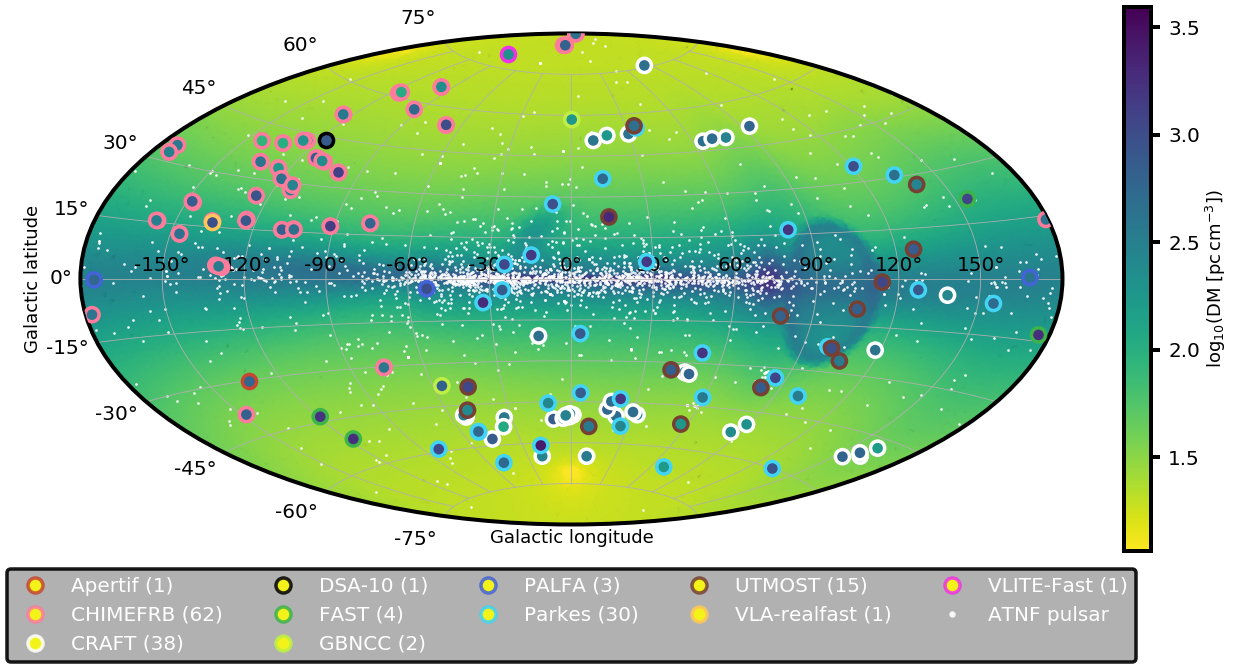

In [20]:
if fileformat=='png':
    matplotlib.rc('axes',edgecolor=framecolour)
    fig = plt.figure(figsize=(22, 10))
elif fileformat=='pdf':
    fig = plt.figure(figsize=(18, 8))
    framecolour='Black'
    
if not Pushchino:
    frb_df = frb_df[frb_df['telescope']!='Pushchino']

# Plot using the Aitoff projection
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)

# Label the axes
ax.set_ylabel('Galactic latitude', fontsize=18,
              color=framecolour)
ax.set_xlabel('Galactic longitude', fontsize=18,
              color=framecolour)

# Plot the DM background
# (It isn't fancy but it works)
cmesh = ax.scatter(-1*bg_dm['gl_rad'], bg_dm['gb_rad'],
                   marker='o',
                   c=bg_dm['logDM'],
                   cmap=DM_cmap,
                   s=40, alpha=0.5,
                   edgecolor='None',
                   vmin=np.amin(bg_dm['logDM']),
                   vmax=np.amax(bg_dm['logDM']))
ax.patch.set_facecolor('Black')

# Plot the pulsars
ax.scatter(-1*psr_glong_rad, psr_glat_rad,
           s=3, c=psrcolour, alpha=0.8,
           edgecolor=psrcolour)
psrartist = plt.Line2D((0, 1), (0, 0),
                       color=psrcolour,
                       marker='o', linestyle='',
                       markeredgecolor=psrcolour,
                       markeredgewidth=lw,
                       alpha=alpha,
                       markersize=3)
psrlabel = 'ATNF pulsar'

# Plot a colourbar matching the
# background heatmap
cbar = plt.colorbar(cmesh)
cbar.set_label(cmap_label, fontsize=18, color=framecolour)
cbar.ax.yaxis.set_tick_params(color=framecolour)
cbar.outline.set_edgecolor(framecolour)
cbar.set_alpha(1)
cbar.draw_all()
bob = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=framecolour)

telescope_artists = []
telescope_labels = []
unique_telescopes = np.unique(frb_df['telescope'])

for t, tel in enumerate(unique_telescopes):
    telescope_frbs = frb_df[frb_df['telescope']==tel]
    
    ax.scatter(-1*telescope_frbs['gl_rad'],
               telescope_frbs['gb_rad'],
               s=200,
               marker=frb_markers,
               linewidth=lw, alpha=1.0,
               edgecolor=telescope_frbs['telescope colours'],
               c=telescope_frbs['logDM'], cmap=DM_cmap,
               vmin=np.nanmin(bg_dm['logDM']),
               vmax=np.nanmax(bg_dm['logDM']), zorder=3)
    try:
        # This is to set up the artist
        # for the legend
        artist = plt.Line2D((0, 1), (0, 0), color='Yellow',
                        marker='o', linestyle='',
                        markeredgewidth=lw, alpha=alpha,
                        markersize=15,
                        markeredgecolor=np.array(telescope_frbs['telescope colours'])[0])
    except IndexError:
        print(tel)
        print(telescope_frbs['telescope colours'])
    
    # This is the label for the legend
    label = '{0} ({1})'.format(tel, len(telescope_frbs['gb_rad']))
    
    # Add to the legend artists and labels
    telescope_artists.append(artist)
    telescope_labels.append(label)
telescope_artists.append(psrartist)
telescope_labels.append(psrlabel)

# Set up the legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1, 2)
leg = ax.legend([handle for i,handle in enumerate(handles) if i in display]+telescope_artists,
                  [label for i,label in enumerate(labels) if i in display]+telescope_labels,
                  numpoints=1, fontsize=20, ncol=5, loc='lower center',
                  bbox_to_anchor=(0.5, -0.3), framealpha=0.9)

# Change the legend colour and fontcolour
leg.get_frame().set_facecolor('DarkGrey')
leg.get_frame().set_edgecolor(framecolour)
leg.get_frame().set_linewidth(lw)
for text in leg.get_texts():
    plt.setp(text, color = 'White')

date = time.strftime('%Y.%m.%d')
savename = '{0}_FRBlocations_{1}Frame_{2}.{3}'.format(date, framecolour, DM_cmap, fileformat)
    
# If save == True, save as a pdf
# Adjust suffix as per plotted objects
if save & ('pdf' in fileformat):
    print('Saving as a {} pdf'.format(framecolour))
    print('Saving as: {}'.format(savename))
    fig.savefig(savename,
                format=fileformat,
                bbox_inches='tight')
elif (save &
      ('png' in fileformat)):
    print('Saving as a {} png'.format(framecolour))
    print('Saving as: {}'.format(savename))
    fig.savefig(savename,
                format=fileformat,
                bbox_inches='tight',
                transparent=True)
if close:
    plt.close()